# 简介

赛题链接： 

## 赛事背景

对于移动设备厂商而言，获取当前手机用户的人口属性信息是非常困难的。基于用户的手机及日常使用应用程序的偏好准确地预测其人口属性信息是提升个性化体验、构建精准用户画像的基础。需要说明的是，本赛事数据已获得个人用户的充分认可和同意，并已进行适当的匿名处理以保护隐私。由于保密，我们不会提供有关如何获得性别和年龄数据的详细信息。


## 赛事任务

本次比赛有两个任务，分别对移动设备（device_id）进行性别和年龄的预测，这里包含二分类和回归两个问题，最终会将两个部分的分数结合起来进行排名。

## 评审规则

1. 数据说明

赛题数据由训练集、测试集、事件数据组成。总设备id超过2w，包含设备信息、APP信息和事件信息，其中device_id为用户的唯一标识符，gender为用户性别，age为用户年龄。为了保证比赛的公平性，将会从中抽取2w条设备id为训练集，3千多个设备id作为测试集，同时会对部分字段信息进行脱敏。


<img src="./pic/data.png" width = "300" height = "150" alt="data" align=center />
 

2. 评估指标

本次竞赛的评价标准由两部分组成，性别预测使用准确率指标，年龄预测使用1/(MAE+1)，最高分为2。评估代码参考：

In [ ]:
from sklearn.metrics import accuracy_score,mean_absolute_error
# standard 为标准答案
# submit 为选手提交答案
score1 = accuracy_score(standard['gender'], submit['gender'])
score2 = 1 / (1 + mean_absolute_error(standard['age'], submit['age']))
# 最终分数
final_score = score1 + score2


3. 评测及排行

1、赛事提供下载数据，选手在本地进行算法调试，在比赛页面提交结果。

2、每支团队每天最多提交3次。

3、排行按照得分从高到低排序，排行榜将选择团队的历史最优成绩进行排名。

## 作品提交要求

文件格式：预测结果文件按照csv格式

提交文件大小：无要求

提交次数限制：每支队伍每周最多3次

预测结果文件详细说明：

1) 以csv格式提交，编码为UTF-8，第一行为表头；

2) 提交前请确保预测结果的格式与sample_submit.csv中的格式一致。具体格式如下：

In [ ]:
device_id,gender,age

20000,0,0

20001,0,0

20002,0,0

20003,0,0

20004,0,0

## 赛程规则

正式赛

8月16日——9月15日

初赛截止成绩以团队在初赛时间段内最优成绩为准（不含测试排名）。

初赛作品提交截止日期为9月8日17:00；正式赛名次公布日期为9月9日10:00。

长期赛

9月16日——10月24日

因赛事以学习实践为主，正式赛将转变为长期赛，供开发者学习实践。本阶段提交后，系统会根据成绩持续更新榜单，但该阶段榜单不再进行公示和奖励。

六、奖项设置

本赛题设立一、二、三等奖各一名，具体详情如下：

一等奖：1支队伍，周赛一等奖证书，奖金：1000元

二等奖：1支队伍，周赛二等奖证书，奖金：800元

三等奖：1支队伍，周赛三等奖证书，奖金：500元

# 赛题Baseline

## 导入常用工具包&读取数据

### 常用工具包导入



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import gc
import glob
from joblib import Parallel, delayed
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold 
import lightgbm as lgbm  


### 数据读取

In [2]:
data_path = './data/' 
df_tr               = pd.read_csv(data_path + 'train.csv')
df_tr_app_events    = pd.read_csv(data_path + 'train_app_events.csv')
df_te               = pd.read_csv(data_path + 'test.csv')
df_te_app_events    = pd.read_csv(data_path + 'test_app_events.csv') 

In [ ]:
df_tr_te_app_events = pd.concat([df_tr_app_events,df_te_app_events],axis=0,ignore_index = True) 

## 数据分析

In [15]:
df_tr_te_app_events.head()

,event_id,app_id,is_installed,is_active,device_id,tag_list,date
0,6,0,1,1,14271,"[549, 721, 704, 302, 303, 548, 183]",1
1,6,1,1,1,14271,"[713, 704, 548]",1
2,6,2,1,1,14271,"[549, 710, 704, 548, 172]",1
3,6,3,1,1,14271,"[548, 549]",1
4,6,4,1,1,14271,"[128, 1014]",1


### gender

- gender一共有两个不同的值，0和1，分布看起来相对均匀

In [13]:
df_tr['gender'].value_counts().plot(kind = 'bar')


<img src="./pic/gender_distribution.png" width = "400" height = "150" alt="gender_distribution" align=center />


### age

- age主要分布在20-40岁之间

In [12]:
plt.figure(figsize = [10,8])
sns.distplot(df_tr['age'])


<img src="./pic/age_distribution.png" width = "400" height = "150" alt="age_distribution" align=center />


### date

- date的分布较为均匀

<AxesSubplot:>

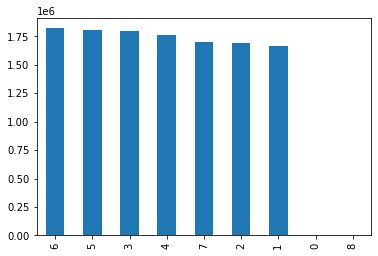

In [18]:
df_tr_te_app_events['date'].value_counts().plot(kind = 'bar')

### event_id

- event_id的分布并不均衡，有很多值为1

In [20]:
df_tr_te_app_events['event_id'].value_counts()

3007317    247
2611873    247
2793993    245
1268100    245
3105953    245
          ... 
1456316      1
178732       1
3110362      1
2946474      1
1349305      1
Name: event_id, Length: 556375, dtype: int64

### app_id

- app_id的较小的出现次数较多。

/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='app_id', ylabel='Density'>

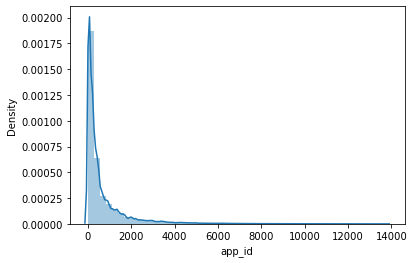

In [25]:
sns.distplot(df_tr_te_app_events['app_id'])

In [26]:
df_tr_te_app_events['app_id'].value_counts()

8        433103
2        338678
30       304719
84       239018
3        147057
          ...  
11906         1
13439         1
13437         1
13434         1
9513          1
Name: app_id, Length: 13762, dtype: int64

### 小结

从上面的基础分析来看，本次赛题的数据基本符合我们的直观理解。至于其它的细节，大家可以根据自己的需求进行分析。下面我们构建该赛题的Baseline。

## 模型构建
### 特征工程

#### tag_list的长度

In [35]:
df_tr_te_app_events['tag_list_len'] = df_tr_te_app_events['tag_list'].apply(lambda x: x.count(',')+1)

#### 基础特征工程

- event_id：出现次数&不同值；
- app_id：出现的不同值；
- is_installed：均值和和；
- is_active：均值和和；
- date：最大值，不同值；
- tag_list_len：均值和标准差

In [44]:
agg_dic = {
    "event_id":['count','nunique'],
    "app_id":['nunique'], 
    "is_installed":[np.mean,np.sum],
    "is_active":[np.mean,np.sum],
    "date":[np.max, 'nunique'],
    "tag_list_len":[np.mean, np.std] 
}

df_device_features = df_tr_te_app_events.groupby('device_id').agg(agg_dic).reset_index()

fea_names = ['_'.join(c) for c in df_device_features.columns]
df_device_features.columns = fea_names
df_device_features.rename(columns = {'device_id_':'device_id'},inplace = True)

In [48]:
df_device_features.head()

,device_id,event_id_count,event_id_nunique,app_id_nunique,is_installed_mean,is_installed_sum,is_active_mean,is_active_sum,date_amax,date_nunique,tag_list_len_mean,tag_list_len_std
0,0,53,1,53,1,53,0.113208,6,1,1,5.188679,4.578615
1,1,81,3,30,1,81,0.456790,37,6,2,5.049383,3.488915
2,2,154,11,20,1,154,0.727273,112,5,3,6.201299,3.941367
3,3,109,5,24,1,109,0.587156,64,5,4,5.119266,3.338121
4,4,303,6,96,1,303,0.273927,83,6,4,6.260726,4.535512


#### 特征组合

- 常用的count/nunqiue & mean/std组合

In [49]:
df_device_features['event_id_count_nunique_ratio'] = df_device_features['event_id_count'] / df_device_features['event_id_nunique']
df_device_features['tag_list_len_mean_div_std'] = df_device_features['tag_list_len_mean'] / df_device_features['tag_list_len_std']

#### 特征拼接

In [52]:
df_tr = df_tr.merge(df_device_features, on = 'device_id' , how='left')
df_te = df_te.merge(df_device_features, on = 'device_id' , how='left')

In [54]:
del df_tr_te_app_events
gc.collect()

3167

In [55]:
df_tr.head()

,device_id,gender,age,phone_brand,device_model,event_id_count,event_id_nunique,app_id_nunique,is_installed_mean,is_installed_sum,is_active_mean,is_active_sum,date_amax,date_nunique,tag_list_len_mean,tag_list_len_std,event_id_count_nunique_ratio,tag_list_len_mean_div_std
0,0,0,35,0,0,53,1,53,1,53,0.113208,6,1,1,5.188679,4.578615,53.0,1.133242
1,1,1,37,1,1,81,3,30,1,81,0.456790,37,6,2,5.049383,3.488915,27.0,1.447264
2,2,0,32,1,2,154,11,20,1,154,0.727273,112,5,3,6.201299,3.941367,14.0,1.573388
3,3,1,28,1,2,109,5,24,1,109,0.587156,64,5,4,5.119266,3.338121,21.8,1.533577
4,4,0,75,2,3,303,6,96,1,303,0.273927,83,6,4,6.260726,4.535512,50.5,1.380379


In [56]:
df_tr.columns

Index(['device_id', 'gender', 'age', 'phone_brand', 'device_model',
       'event_id_count', 'event_id_nunique', 'app_id_nunique',
       'is_installed_mean', 'is_installed_sum', 'is_active_mean',
       'is_active_sum', 'date_amax', 'date_nunique', 'tag_list_len_mean',
       'tag_list_len_std', 'event_id_count_nunique_ratio',
       'tag_list_len_mean_div_std'],
      dtype='object')

## 模型训练&预测

### 特征&标签设计

In [57]:
tr_features = ['device_id',  'phone_brand', 'device_model', 'event_id_count', 'event_id_nunique', 'app_id_nunique',
       'is_installed_mean', 'is_installed_sum', 'is_active_mean', 'is_active_sum', 'date_amax', 'date_nunique', 'tag_list_len_mean',
       'tag_list_len_std', 'event_id_count_nunique_ratio','tag_list_len_mean_div_std']
label_gender   = 'gender'
label_age      = 'age'

### gender模型

In [74]:
y_valid.value_counts()

0    2668
1    1347
Name: gender, dtype: int64

In [87]:
lgb_params = {
      "objective": "binary", 
      "metric": "binary_error", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 100,
      'learning_rate': 0.01,  
      'colsample_bytree':0.95, 
} 

X_tr_val = df_tr[tr_features + [label_gender]]
X_te     = df_te[tr_features]
 
kf = KFold(n_splits=5)
lgb_gender_models = []
y_pred = 0
for f,(tr_ind,val_ind) in enumerate(kf.split(X_tr_val)):
    
    X_train,X_valid = X_tr_val.iloc[tr_ind][tr_features], X_tr_val.iloc[val_ind][tr_features]
    y_train,y_valid = X_tr_val.iloc[tr_ind][label_gender], X_tr_val.iloc[val_ind][label_gender]
    
    lgbm_train = lgbm.Dataset(X_train,y_train)  
    lgbm_valid = lgbm.Dataset(X_valid,y_valid)

    model_binary = lgbm.train(params=lgb_params, 
                  train_set=lgbm_train,
                  valid_sets=[lgbm_train, lgbm_valid],
                  num_boost_round=100000,   
                  verbose_eval=100)
    y_pred += model_binary.predict(X_te[tr_features]) / 5.0
    lgb_gender_models.append(model_binary) 

/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 5742, number of negative: 10318
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 16060, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.357534 -> initscore=-0.586082
[LightGBM] [Info] Start training from score -0.586082
Training until validation scores don't improve for 100 rounds
[100]	training's binary_error: 0.349004	valid_1's binary_error: 0.343711
[200]	training's binary_error: 0.325903	valid_1's binary_error: 0.341968
Early stopping, best iteration is:
[138]	training's binary_error: 0.341034	valid_1's binary_error: 0.340722
[LightGBM] [Info] Number of positive: 5581, number of negative: 10479
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set

In [88]:
df_submit = df_te[['device_id']].copy()
df_submit['gender'] = (y_pred >=0.5) + 0
df_submit['gender'] = df_submit['gender'].astype(int)

### age模型

In [89]:
from sklearn.metrics import mean_absolute_error
def feval_lgb_Age(preds, lgbm_train):
    
    labels =lgbm_train.get_label()
    return 'Age Error', round(1.0 / (1.0 + mean_absolute_error(y_true = labels, y_pred = preds)),7), True


lgb_params = {
      "objective": "mae",  
      "boosting_type": "gbdt",
      'early_stopping_rounds': 100,
      'learning_rate': 0.01,  
      'colsample_bytree':0.95, 
} 

X_tr_val = df_tr[tr_features + [label_age]]
X_te     = df_te[tr_features]
 
kf = KFold(n_splits=5)
lgb_age_models = []
y_pred = 0
for f,(tr_ind,val_ind) in enumerate(kf.split(X_tr_val)):
    
    X_train,X_valid = X_tr_val.iloc[tr_ind][tr_features], X_tr_val.iloc[val_ind][tr_features]
    y_train,y_valid = X_tr_val.iloc[tr_ind][label_age], X_tr_val.iloc[val_ind][label_age]
    
    lgbm_train = lgbm.Dataset(X_train,y_train)  
    lgbm_valid = lgbm.Dataset(X_valid,y_valid)

    model_mae = lgbm.train(params=lgb_params, 
                  train_set=lgbm_train,
                  valid_sets=[lgbm_train, lgbm_valid],
                  num_boost_round=100000,   
                     feval = feval_lgb_Age,
                  verbose_eval=100)
    y_pred += model_mae.predict(X_te[tr_features]) / 5.0
    lgb_age_models.append(model_mae) 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 16060, number of used features: 15
[LightGBM] [Info] Start training from score 30.000000
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 6.78229	training's Age Error: 0.128497	valid_1's l1: 8.09957	valid_1's Age Error: 0.109895
[200]	training's l1: 6.60257	training's Age Error: 0.131534	valid_1's l1: 8.01598	valid_1's Age Error: 0.110914
[300]	training's l1: 6.47553	training's Age Error: 0.13377	valid_1's l1: 7.9676	valid_1's Age Error: 0.111513
[400]	training's l1: 6.38702	training's Age Error: 0.135373	valid_1's l1: 7.96073	valid_1's Age Error: 0.111598
Early stopping, best iteration is:
[375]	training's l1: 6.40741	training's Age Error: 0.135	valid_1's l1: 7.95786	valid_1's Age Error: 0.111634
[L

/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's l1: 6.89408	training's Age Error: 0.126677	valid_1's l1: 7.58618	valid_1's Age Error: 0.116466
[200]	training's l1: 6.70926	training's Age Error: 0.129714	valid_1's l1: 7.47627	valid_1's Age Error: 0.117976
[300]	training's l1: 6.58554	training's Age Error: 0.13183	valid_1's l1: 7.42871	valid_1's Age Error: 0.118642
[400]	training's l1: 6.48646	training's Age Error: 0.133575	valid_1's l1: 7.405	valid_1's Age Error: 0.118977
[500]	training's l1: 6.40254	training's Age Error: 0.135089	valid_1's l1: 7.39734	valid_1's Age Error: 0.119085
[600]	training's l1: 6.33728	training's Age Error: 0.13629	valid_1's l1: 7.39445	valid_1's Age Error: 0.119126
[700]	training's l1: 6.27831	training's Age Error: 0.137395	valid_1's l1: 7.39564	valid_1's Age Error: 0.119109
Early stopping, best iteration is:
[632]	training's l1: 6.31788	training's Age Error: 0.136652	valid_1's l1: 7.39393	valid_1's Age Error: 0.119134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead

/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Start training from score 30.000000
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 7.11433	training's Age Error: 0.123239	valid_1's l1: 6.59517	valid_1's Age Error: 0.131663
[200]	training's l1: 6.91579	training's Age Error: 0.12633	valid_1's l1: 6.54172	valid_1's Age Error: 0.132596
[300]	training's l1: 6.77959	training's Age Error: 0.128542	valid_1's l1: 6.53539	valid_1's Age Error: 0.132707
[400]	training's l1: 6.68062	training's Age Error: 0.130198	valid_1's l1: 6.52882	valid_1's Age Error: 0.132823
[500]	training's l1: 6.59194	training's Age Error: 0.131719	valid_1's l1: 6.52555	valid_1's Age Error: 0.132881
Early stopping, best iteration is:
[493]	training's l1: 6.59739	training's Age Error: 0.131624	valid_1's l1: 6.52537	valid_1's Age Error: 0.132884
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's l1: 7.10475	training's Age Error: 0.123384	valid_1's l1: 6.68054	valid_1's Age Error: 0.130199
[200]	training's l1: 6.91294	training's Age Error: 0.126375	valid_1's l1: 6.58465	valid_1's Age Error: 0.131845
[300]	training's l1: 6.77547	training's Age Error: 0.12861	valid_1's l1: 6.55076	valid_1's Age Error: 0.132437
[400]	training's l1: 6.67143	training's Age Error: 0.130354	valid_1's l1: 6.53571	valid_1's Age Error: 0.132702
[500]	training's l1: 6.58621	training's Age Error: 0.131818	valid_1's l1: 6.52837	valid_1's Age Error: 0.132831
[600]	training's l1: 6.51966	training's Age Error: 0.132985	valid_1's l1: 6.52825	valid_1's Age Error: 0.132833
Early stopping, best iteration is:
[545]	training's l1: 6.55478	training's Age Error: 0.132366	valid_1's l1: 6.52719	valid_1's Age Error: 0.132852


/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3038
[LightGBM] [Info] Number of data points in the train set: 16060, number of used features: 15
[LightGBM] [Info] Start training from score 30.000000
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 7.07656	training's Age Error: 0.123815	valid_1's l1: 6.79393	valid_1's Age Error: 0.128305
[200]	training's l1: 6.8788	training's Age Error: 0.126923	valid_1's l1: 6.71435	valid_1's Age Error: 0.129629
[300]	training's l1: 6.74541	training's Age Error: 0.129109	valid_1's l1: 6.68214	valid_1's Age Error: 0.130172
[400]	training's l1: 6.63994	training's Age Error: 0.130891	valid_1's l1: 6.66929	valid_1's Age Error: 0.13039
[500]	training's l1: 6.55454	training's Age Error: 0.132371	valid_1's l1: 6.67073	valid_1's Age Error: 0.130366
Early stopping, best iteration is:

In [90]:

df_submit['age'] = y_pred

### 模型提交

In [91]:
df_submit.to_csv('baseline_Fold5_lgb.csv',index = None)

# 结论

本文我们对数据进行了简单的分析并且设计了简单的Baseline，目前模型都还是一些基础的统计特征，可以提升的地方非常多，例如：

- 加强特征工程：比如tag list数据如何充分的利用好；设计序列化的信息来强化用户的刻画；
- 该问题是多目标优化的问题，可以参考Wechat和腾讯之前的比赛，使用一些最新的技术，例如MMOE等进行联合优化；
- 设计NN和树模型等融合